# 02. Adstock & Saturation: The Mathematical Foundations

This notebook explains the mathematical transformations that make Marketing Mix Modeling work. Understanding these concepts is crucial for:

1. **Interpreting results** - What do the parameters mean?
2. **Setting priors** - What are reasonable parameter ranges?
3. **Debugging issues** - Why might the model behave unexpectedly?

## Key Concepts

| Transformation | What It Models | Mathematical Effect |
|----------------|----------------|---------------------|
| **Adstock** | Carryover/Memory | Yesterday's ad spend still affects today's sales |
| **Saturation** | Diminishing Returns | Doubling spend doesn't double response |

---

## 1. Adstock: Modeling Advertising Memory

### The Problem
When you run a TV ad today, sales don't just spike today and return to baseline tomorrow. The effect **carries over** - people remember the ad, search for it later, or are primed for future touchpoints.

### The Solution: Adstock Transformation
Adstock creates a "memory" of past advertising by weighting historical spend:

```
adstock[t] = Σ (weight[k] × spend[t-k])  for k = 0, 1, 2, ...
```

This is mathematically a **convolution** operation.

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import weibull_min
import sys
from pathlib import Path

# Add src to path for imports
src_path = Path('../src').resolve()
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

# Import our transform functions
try:
    from transforms import (
        geometric_adstock, 
        weibull_adstock, 
        delayed_adstock,
        hill_saturation, 
        logistic_saturation, 
        estimate_marginal_response
    )
    print("All transform functions imported successfully!")
except ImportError as e:
    print(f"Import error: {e}")
    print("\nTrying alternative import method...")
    # Fallback: direct imports
    from transforms.adstock import geometric_adstock, weibull_adstock, delayed_adstock
    from transforms.saturation import hill_saturation, logistic_saturation, estimate_marginal_response
    print("Imported using direct module paths")

plt.style.use('seaborn-v0_8-whitegrid')
np.random.seed(42)

print("Libraries loaded and ready!")

Import error: cannot import name 'estimate_marginal_response' from 'transforms' (/Users/varma/Desktop/Git/Unified-M/notebooks/../src/transforms/__init__.py)

Trying alternative import method...
Imported using direct module paths
Libraries loaded and ready!


## 1.1 Geometric Adstock (Exponential Decay)

The most common adstock model. Effect decays exponentially over time.

### Mathematical Formula

**Recursive form:**
$$\text{adstock}[t] = x[t] + \alpha \cdot \text{adstock}[t-1]$$

**Closed form (using convolution):**
$$\text{adstock}[t] = \sum_{k=0}^{L} w_k \cdot x[t-k]$$

where weights are:
$$w_k = \frac{\alpha^k}{\sum_{i=0}^{L} \alpha^i} \quad \text{(normalized)}$$

### Parameters

| Parameter | Range | Interpretation |
|-----------|-------|----------------|
| α (alpha) | [0, 1] | Decay rate. Higher = longer memory |
| L (l_max) | int | Maximum lag to consider |

### Key Metrics

- **Half-life**: Time for effect to decay to 50%
  $$t_{1/2} = \frac{\ln(0.5)}{\ln(\alpha)}$$

- **90%-life**: Time for 90% of cumulative effect
  $$t_{90} = \frac{\ln(0.1)}{\ln(\alpha)}$$

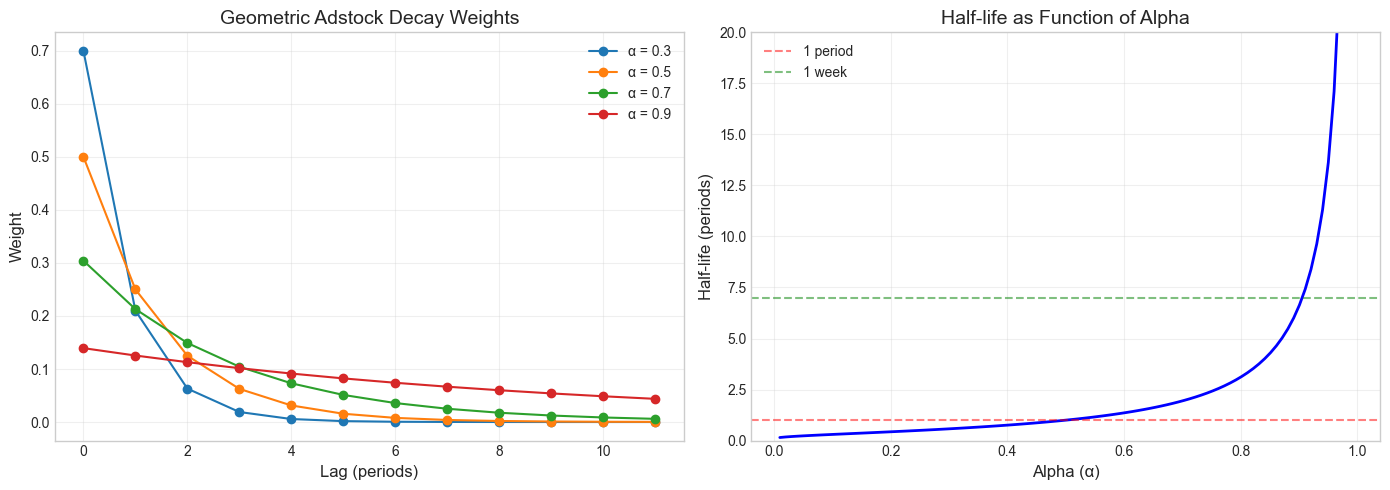


Half-life by Alpha:
------------------------------
α = 0.3: 0.6 periods
α = 0.5: 1.0 periods
α = 0.7: 1.9 periods
α = 0.8: 3.1 periods
α = 0.9: 6.6 periods
α = 0.95: 13.5 periods


In [9]:
# Visualize geometric adstock decay weights for different alpha values
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Decay weights
alphas = [0.3, 0.5, 0.7, 0.9]
l_max = 12
lags = np.arange(l_max)

for alpha in alphas:
    weights = np.array([alpha ** i for i in range(l_max)])
    weights_normalized = weights / weights.sum()
    axes[0].plot(lags, weights_normalized, 'o-', label=f'α = {alpha}', markersize=6)

axes[0].set_xlabel('Lag (periods)', fontsize=12)
axes[0].set_ylabel('Weight', fontsize=12)
axes[0].set_title('Geometric Adstock Decay Weights', fontsize=14)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Right: Half-life vs Alpha
alpha_range = np.linspace(0.01, 0.99, 100)
half_life = np.log(0.5) / np.log(alpha_range)

axes[1].plot(alpha_range, half_life, 'b-', linewidth=2)
axes[1].set_xlabel('Alpha (α)', fontsize=12)
axes[1].set_ylabel('Half-life (periods)', fontsize=12)
axes[1].set_title('Half-life as Function of Alpha', fontsize=14)
axes[1].axhline(y=1, color='r', linestyle='--', alpha=0.5, label='1 period')
axes[1].axhline(y=7, color='g', linestyle='--', alpha=0.5, label='1 week')
axes[1].set_ylim(0, 20)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print half-life table
print("\nHalf-life by Alpha:")
print("-" * 30)
for alpha in [0.3, 0.5, 0.7, 0.8, 0.9, 0.95]:
    hl = np.log(0.5) / np.log(alpha)
    print(f"α = {alpha}: {hl:.1f} periods")

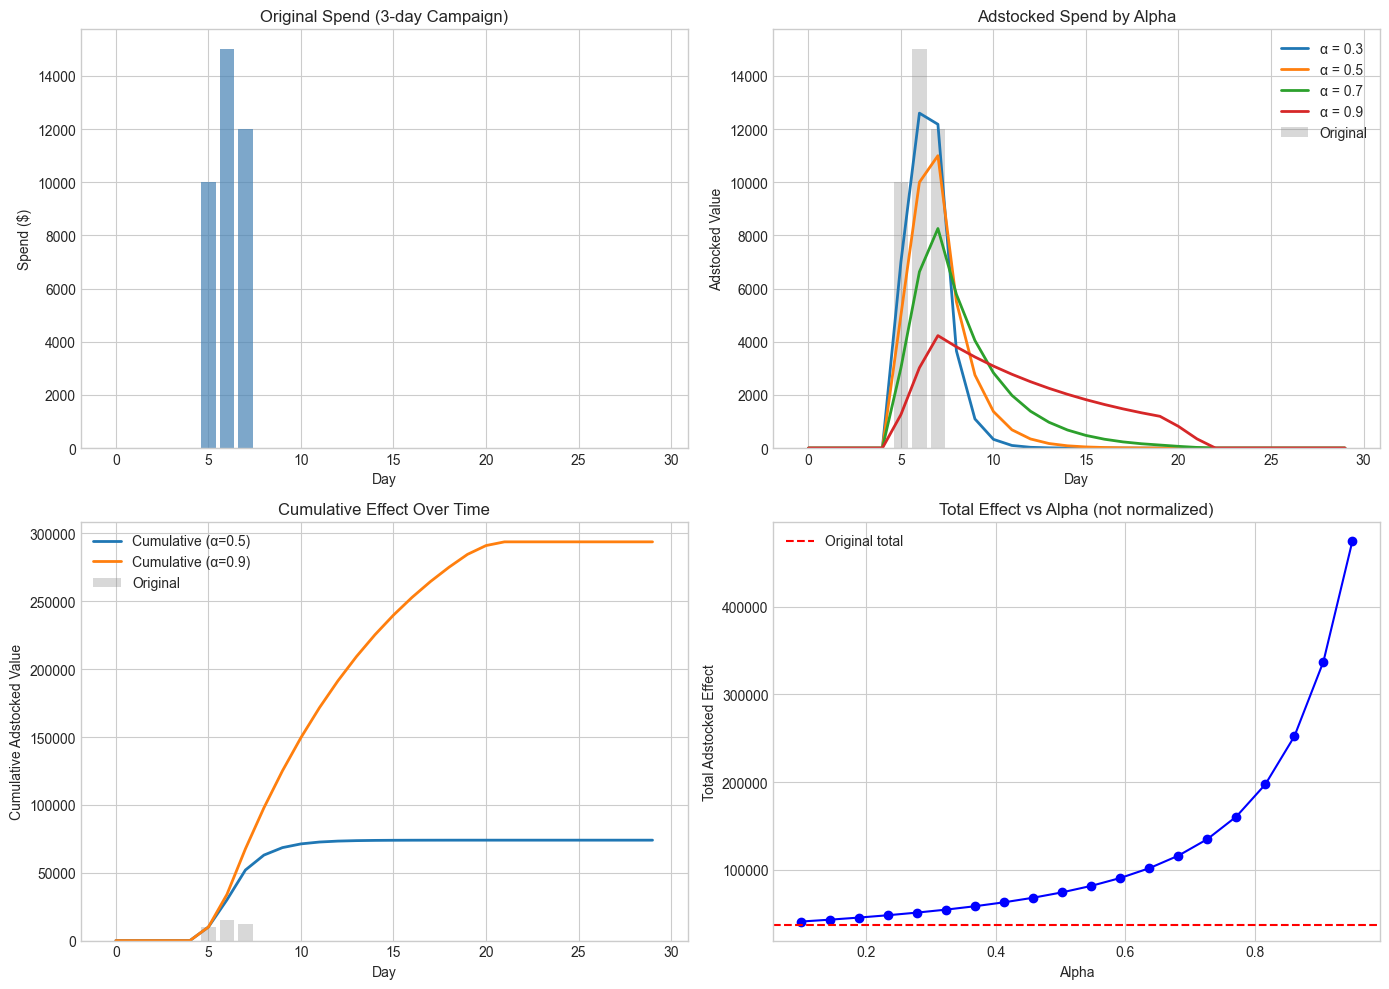

In [10]:
# Demonstrate adstock on a real-world example
# Simulate a campaign with a pulse of spend

# Create spend pattern: nothing, then a pulse, then nothing
n_days = 30
spend = np.zeros(n_days)
spend[5:8] = [10000, 15000, 12000]  # 3-day campaign burst

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Original spend
axes[0, 0].bar(range(n_days), spend, color='steelblue', alpha=0.7)
axes[0, 0].set_title('Original Spend (3-day Campaign)', fontsize=12)
axes[0, 0].set_xlabel('Day')
axes[0, 0].set_ylabel('Spend ($)')

# Plot 2: Compare different alphas
for alpha in [0.3, 0.5, 0.7, 0.9]:
    adstocked = geometric_adstock(spend, alpha=alpha, l_max=15)
    axes[0, 1].plot(range(n_days), adstocked, label=f'α = {alpha}', linewidth=2)

axes[0, 1].bar(range(n_days), spend, color='gray', alpha=0.3, label='Original')
axes[0, 1].set_title('Adstocked Spend by Alpha', fontsize=12)
axes[0, 1].set_xlabel('Day')
axes[0, 1].set_ylabel('Adstocked Value')
axes[0, 1].legend()

# Plot 3: Cumulative effect
axes[1, 0].bar(range(n_days), spend, color='gray', alpha=0.3, label='Original')
for alpha in [0.5, 0.9]:
    adstocked = geometric_adstock(spend, alpha=alpha, l_max=15, normalize=False)
    cumsum = np.cumsum(adstocked)
    axes[1, 0].plot(range(n_days), cumsum, label=f'Cumulative (α={alpha})', linewidth=2)

axes[1, 0].set_title('Cumulative Effect Over Time', fontsize=12)
axes[1, 0].set_xlabel('Day')
axes[1, 0].set_ylabel('Cumulative Adstocked Value')
axes[1, 0].legend()

# Plot 4: Area under curve comparison
alphas = np.linspace(0.1, 0.95, 20)
total_effects = []
for alpha in alphas:
    adstocked = geometric_adstock(spend, alpha=alpha, l_max=20, normalize=False)
    total_effects.append(np.sum(adstocked))

axes[1, 1].plot(alphas, total_effects, 'bo-', markersize=6)
axes[1, 1].axhline(y=np.sum(spend), color='r', linestyle='--', label='Original total')
axes[1, 1].set_xlabel('Alpha')
axes[1, 1].set_ylabel('Total Adstocked Effect')
axes[1, 1].set_title('Total Effect vs Alpha (not normalized)', fontsize=12)
axes[1, 1].legend()

plt.tight_layout()
plt.show()

## 2. Saturation: Modeling Diminishing Returns

### The Problem
If $1,000 in Google Ads generates 10 conversions, does $10,000 generate 100 conversions? 

**No!** Due to:
- Audience exhaustion (you've reached everyone interested)
- Increased competition for impressions
- Lower-intent users at higher reach

### The Solution: Saturation Functions

Saturation transforms raw spend into an "effective" spend that accounts for diminishing returns.

---

## 2.1 Hill Function (Most Common)

The Hill function (also called Hill-Langmuir equation) comes from biochemistry but works perfectly for advertising saturation.

### Mathematical Formula

$$y = \frac{x^S}{K^S + x^S}$$

### Parameters

| Parameter | Range | Interpretation |
|-----------|-------|----------------|
| K | > 0 | Half-saturation point (EC50). Spend at 50% max effect |
| S | > 0 | Hill coefficient. Steepness of curve |

### Properties

1. **At x = 0**: y = 0 (no spend = no effect)
2. **At x = K**: y = 0.5 (half max effect)
3. **As x → ∞**: y → 1 (maximum effect)
4. **Output range**: [0, 1]

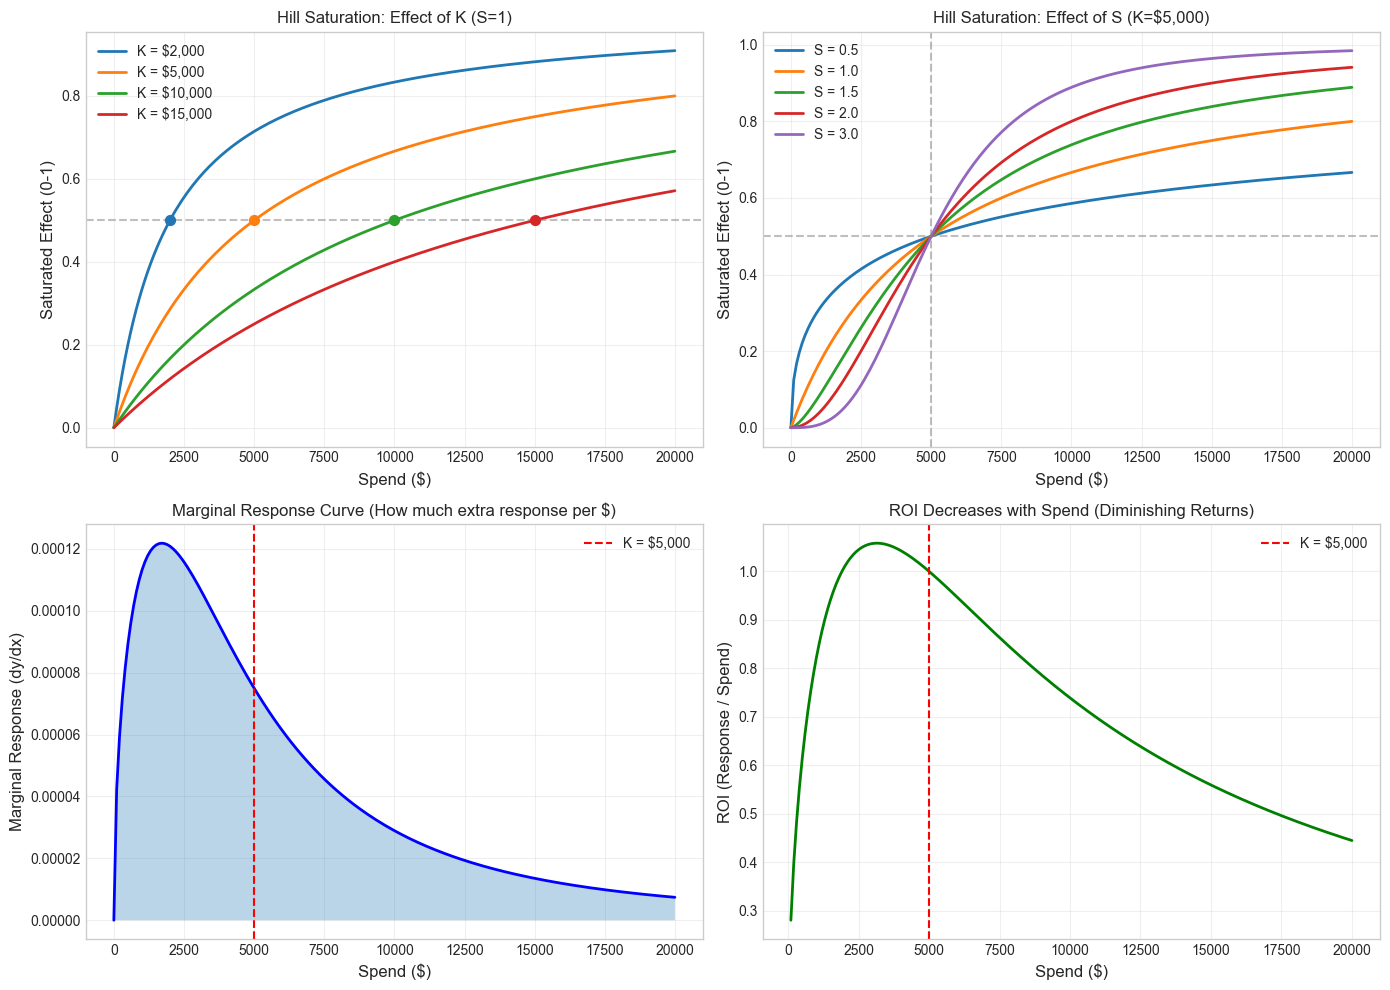

In [11]:
# Visualize Hill saturation function
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

spend = np.linspace(0, 20000, 200)

# Plot 1: Effect of K (half-saturation point)
K_values = [2000, 5000, 10000, 15000]
S = 1.0

for K in K_values:
    saturated = hill_saturation(spend, K=K, S=S)
    axes[0, 0].plot(spend, saturated, label=f'K = ${K:,}', linewidth=2)
    # Mark the half-saturation point
    axes[0, 0].scatter([K], [0.5], s=50, zorder=5)

axes[0, 0].axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
axes[0, 0].set_xlabel('Spend ($)', fontsize=12)
axes[0, 0].set_ylabel('Saturated Effect (0-1)', fontsize=12)
axes[0, 0].set_title('Hill Saturation: Effect of K (S=1)', fontsize=12)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Effect of S (steepness)
K = 5000
S_values = [0.5, 1.0, 1.5, 2.0, 3.0]

for S in S_values:
    saturated = hill_saturation(spend, K=K, S=S)
    axes[0, 1].plot(spend, saturated, label=f'S = {S}', linewidth=2)

axes[0, 1].axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
axes[0, 1].axvline(x=K, color='gray', linestyle='--', alpha=0.5)
axes[0, 1].set_xlabel('Spend ($)', fontsize=12)
axes[0, 1].set_ylabel('Saturated Effect (0-1)', fontsize=12)
axes[0, 1].set_title(f'Hill Saturation: Effect of S (K=${K:,})', fontsize=12)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Marginal response (derivative)
K = 5000
S = 1.5

marginal = estimate_marginal_response(spend, saturation_type='hill', K=K, S=S)
axes[1, 0].plot(spend, marginal, 'b-', linewidth=2)
axes[1, 0].fill_between(spend, marginal, alpha=0.3)
axes[1, 0].axvline(x=K, color='r', linestyle='--', label=f'K = ${K:,}')
axes[1, 0].set_xlabel('Spend ($)', fontsize=12)
axes[1, 0].set_ylabel('Marginal Response (dy/dx)', fontsize=12)
axes[1, 0].set_title('Marginal Response Curve (How much extra response per $)', fontsize=12)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: ROI at different spend levels
K = 5000
S = 1.5
coefficient = 10000  # Assume $10,000 max contribution

total_response = coefficient * hill_saturation(spend, K=K, S=S)
roi = total_response / (spend + 1)  # Avoid division by zero

axes[1, 1].plot(spend[1:], roi[1:], 'g-', linewidth=2)
axes[1, 1].axvline(x=K, color='r', linestyle='--', label=f'K = ${K:,}')
axes[1, 1].set_xlabel('Spend ($)', fontsize=12)
axes[1, 1].set_ylabel('ROI (Response / Spend)', fontsize=12)
axes[1, 1].set_title('ROI Decreases with Spend (Diminishing Returns)', fontsize=12)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Putting It Together: The Full Transform Pipeline

In an MMM, we typically apply **adstock first, then saturation**:

$$\text{effect}[t] = \beta \times \text{saturate}(\text{adstock}(x[t]))$$

### Why This Order?

1. **Adstock first**: Accumulates historical spend into current period
2. **Saturation second**: Applies diminishing returns to the accumulated stock

The adstocked value represents the "effective" advertising pressure, and saturation limits how much of that pressure converts to outcomes.

### The Complete Transformation

```
Raw Spend → [Adstock] → Adstocked Spend → [Saturation] → Saturated Effect → [× Coefficient] → Contribution
```

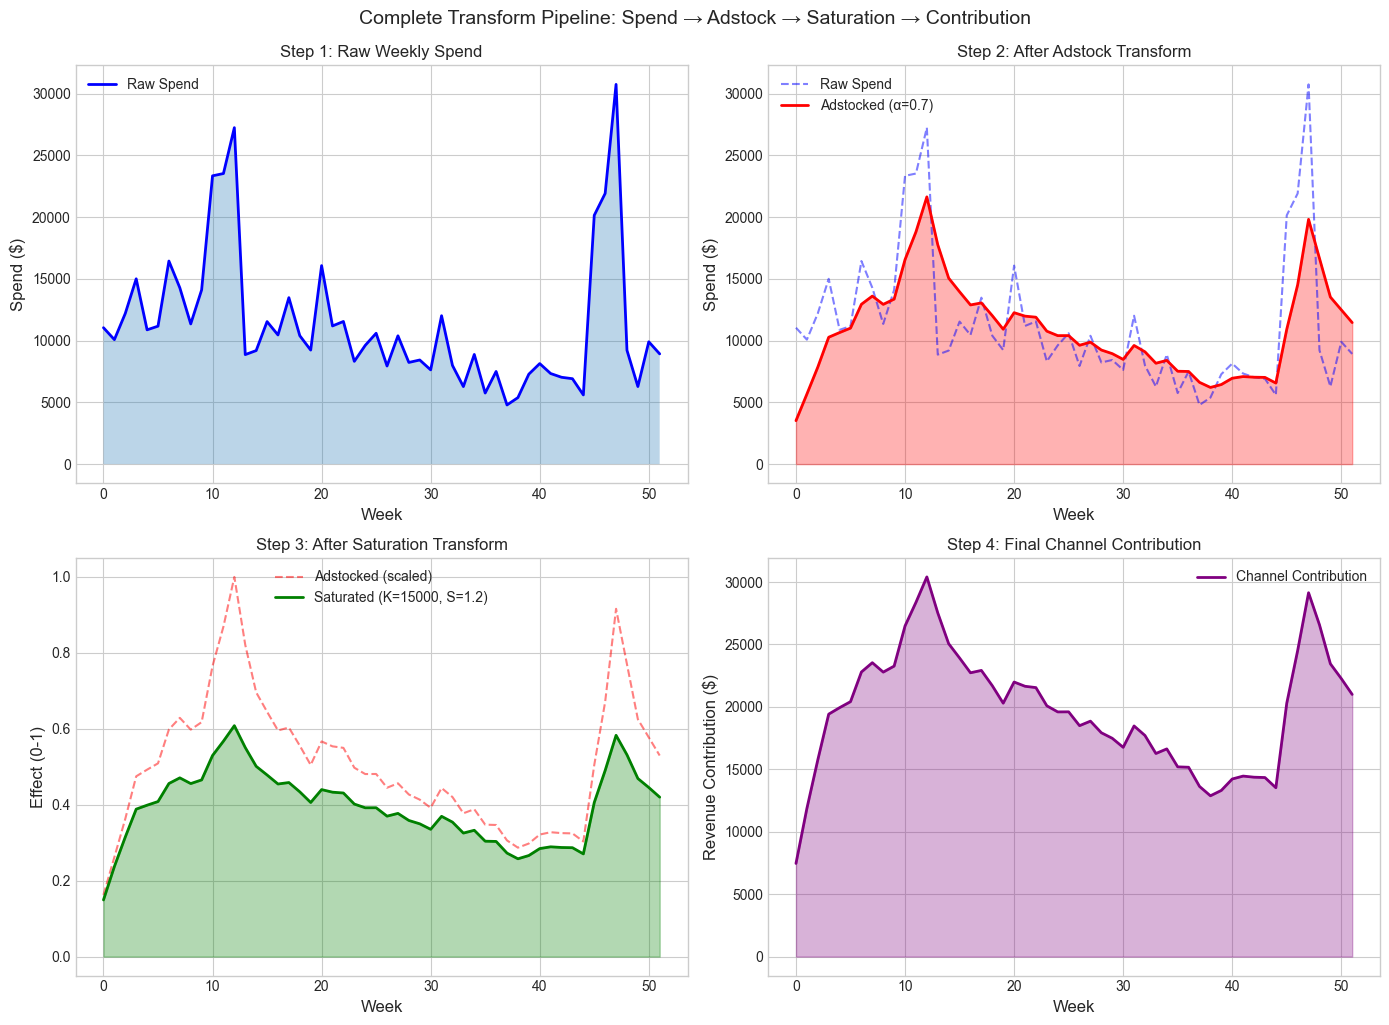


Transformation Summary:
Raw spend - Total: $591,809, Max: $30,747
Adstocked  - Total: $571,969, Max: $21,638
Saturated  - Mean: 0.395, Max: 0.608
Contribution - Total: $1,028,042


In [12]:
# Demonstrate the full pipeline with a realistic example

# Generate realistic spend data (weekly pattern with seasonality)
n_weeks = 52
weeks = np.arange(n_weeks)

# Base spend with seasonality and some random variation
base_spend = 10000
seasonality = 1 + 0.3 * np.sin(2 * np.pi * weeks / 52)  # Annual cycle
noise = np.random.lognormal(0, 0.2, n_weeks)
spend = base_spend * seasonality * noise

# Add some campaign bursts
spend[10:13] *= 2.0  # Spring campaign
spend[45:48] *= 3.0  # Holiday campaign

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Raw spend
axes[0, 0].plot(weeks, spend, 'b-', linewidth=2, label='Raw Spend')
axes[0, 0].fill_between(weeks, spend, alpha=0.3)
axes[0, 0].set_xlabel('Week', fontsize=12)
axes[0, 0].set_ylabel('Spend ($)', fontsize=12)
axes[0, 0].set_title('Step 1: Raw Weekly Spend', fontsize=12)
axes[0, 0].legend()

# Plot 2: After adstock
alpha = 0.7
adstocked = geometric_adstock(spend, alpha=alpha, l_max=8)

axes[0, 1].plot(weeks, spend, 'b--', alpha=0.5, label='Raw Spend')
axes[0, 1].plot(weeks, adstocked, 'r-', linewidth=2, label=f'Adstocked (α={alpha})')
axes[0, 1].fill_between(weeks, adstocked, alpha=0.3, color='red')
axes[0, 1].set_xlabel('Week', fontsize=12)
axes[0, 1].set_ylabel('Spend ($)', fontsize=12)
axes[0, 1].set_title('Step 2: After Adstock Transform', fontsize=12)
axes[0, 1].legend()

# Plot 3: After saturation
K = 15000
S = 1.2
saturated = hill_saturation(adstocked, K=K, S=S)

# Scale adstocked for comparison (avoid division by zero)
adstocked_scaled = adstocked / (adstocked.max() + 1e-10) if adstocked.max() > 0 else adstocked
axes[1, 0].plot(weeks, adstocked_scaled, 'r--', alpha=0.5, label='Adstocked (scaled)')
axes[1, 0].plot(weeks, saturated, 'g-', linewidth=2, label=f'Saturated (K={K}, S={S})')
axes[1, 0].fill_between(weeks, saturated, alpha=0.3, color='green')
axes[1, 0].set_xlabel('Week', fontsize=12)
axes[1, 0].set_ylabel('Effect (0-1)', fontsize=12)
axes[1, 0].set_title('Step 3: After Saturation Transform', fontsize=12)
axes[1, 0].legend()

# Plot 4: Final contribution
coefficient = 50000  # Channel's total contribution potential
contribution = coefficient * saturated

axes[1, 1].plot(weeks, contribution, 'purple', linewidth=2, label='Channel Contribution')
axes[1, 1].fill_between(weeks, contribution, alpha=0.3, color='purple')
axes[1, 1].set_xlabel('Week', fontsize=12)
axes[1, 1].set_ylabel('Revenue Contribution ($)', fontsize=12)
axes[1, 1].set_title('Step 4: Final Channel Contribution', fontsize=12)
axes[1, 1].legend()

plt.tight_layout()
plt.suptitle('Complete Transform Pipeline: Spend → Adstock → Saturation → Contribution', 
             fontsize=14, y=1.02)
plt.show()

# Summary statistics
print("\nTransformation Summary:")
print("=" * 50)
print(f"Raw spend - Total: ${spend.sum():,.0f}, Max: ${spend.max():,.0f}")
print(f"Adstocked  - Total: ${adstocked.sum():,.0f}, Max: ${adstocked.max():,.0f}")
print(f"Saturated  - Mean: {saturated.mean():.3f}, Max: {saturated.max():.3f}")
print(f"Contribution - Total: ${contribution.sum():,.0f}")

## 4. Parameter Guidelines by Channel

Different channels have different carryover and saturation characteristics:

| Channel | Typical alpha (Adstock) | Typical K | Notes |
|---------|---------------------|-----------|-------|
| TV Linear | 0.7-0.9 | High | Long memory, high saturation threshold |
| Search (Brand) | 0.1-0.3 | Low | Immediate intent, low carryover |
| Search (Generic) | 0.2-0.4 | Medium | Some consideration time |
| Social (Facebook) | 0.4-0.6 | Medium | Visual, moderate memory |
| Display | 0.3-0.5 | Medium-Low | Awareness, builds over time |
| Radio | 0.5-0.7 | Medium | Audio memory effect |
| OOH | 0.6-0.8 | High | Requires frequency |

### Rules of Thumb

1. High funnel channels (TV, OOH) -> Higher alpha, Higher K
2. Low funnel channels (Search, Retargeting) -> Lower alpha, Lower K
3. Longer consideration (B2B, Luxury) -> Higher alpha
4. Impulse purchases (FMCG, Mobile) -> Lower alpha

## Summary

- Adstock models the carryover of advertising effect over time
- Saturation models diminishing returns at high spend levels
- Together, they transform raw spend into a realistic representation of advertising impact
- Parameters should be guided by domain knowledge and validated with incrementality tests

Next: Proceed to 03_mmm_model_training.ipynb to see how these transforms integrate into the full Bayesian model.